# Exploratory Data Analysis


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
import numpy as np

df = pd.read_json(
    "https://huggingface.co/datasets/copenlu/scientific-exaggeration-detection/resolve/main/train.jsonl",
    lines=True
)

/home/jubacochran/miniforge3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df

,original_file_id,press_release_conclusion,press_release_strength,abstract_conclusion,abstract_strength,exaggeration_label
0,25-002,Use of the urgent referral pathway (often call...,3,Use of the urgent referral pathway could be ef...,2,exaggerates
1,22-001,Dementia patients from more affluent areas in ...,1,Least deprived patients were 25% more likely t...,1,same
2,26-002,Meeting patients' preferences for the time and...,2,People who reported preferences that were not ...,1,exaggerates
3,19-11-004-1,Crossing your arms relieves pain,3,Besides studies showing relief of phantom limb...,2,exaggerates
4,25-027,Oral contraceptive use just before or during p...,0,"Residual confounding was possible, and the ana...",0,same
...,...,...,...,...,...,...
95,22-006,People bereaved by the sudden death of a frien...,1,Bereavement by suicide is a specific risk fact...,1,same
96,20-11-005-1,Infants who have problems with persistent cryi...,1,The meta-analyses suggest that children with p...,1,same
97,14-11-029-1,Simple test to help diagnose bowel and pancrea...,3,The algorithm has good discrimination and cali...,2,exaggerates
98,03-11-035-1,Scientists identify cause of severe hypoglycaemia,3,"In heterologous cells, the mutant AKT2 was con...",3,same


In [3]:
df["string_counts"] = df["press_release_conclusion"].str.len()

df_sorted = df.sort_values("string_counts", ascending=False)[
    ["press_release_conclusion", "string_counts"]
]

df_sorted.head(10)

,press_release_conclusion,string_counts
86,“Our results show that reducing the amount of ...,544
5,Scientists at the UCL Institute of Ophthalmolo...,488
43,"The study, led by Dr Jonathan Banks from the U...",441
27,In the first functional MRI brain scan study t...,383
23,Scientists have identified a protein that acts...,336
78,Pregnant women would be willing to trial mater...,294
2,Meeting patients' preferences for the time and...,282
95,People bereaved by the sudden death of a frien...,282
51,Plain cigarette packaging could help prevent p...,277
1,Dementia patients from more affluent areas in ...,277


In [4]:
s = df["press_release_conclusion"].str.len()

stats = s.describe(percentiles=[0.5, 0.9, 0.95, 0.99]).to_frame(name="press_release_conclusion_len")
stats

,press_release_conclusion_len
count,100.000000
mean,175.570000
std,95.838801
min,17.000000
50%,183.000000
90%,275.200000
95%,296.100000
99%,488.560000
max,544.000000


In [5]:
text_cols = ["press_release_conclusion", "abstract_conclusion"]

length_summary = {}
for c in text_cols:
    lens = df[c].str.len()
    length_summary[c] = {
        "min": int(lens.min()),
        "mean": float(lens.mean()),
        "p50": float(lens.quantile(0.50)),
        "p90": float(lens.quantile(0.90)),
        "p95": float(lens.quantile(0.95)),
        "p99": float(lens.quantile(0.99)),
        "max": int(lens.max()),
    }

pd.DataFrame(length_summary).T


,min,mean,p50,p90,p95,p99,max
press_release_conclusion,17.0,175.57,183.0,275.2,296.10,488.56,544.0
abstract_conclusion,51.0,166.88,167.0,241.1,260.65,308.44,352.0


In [6]:
#Worse outliers
df.loc[df["press_release_conclusion"].str.len().nlargest(20).index,
       ["press_release_conclusion", "abstract_conclusion"]]


,press_release_conclusion,abstract_conclusion
86,“Our results show that reducing the amount of ...,"In particular, VEGF was found to regulate cell..."
5,Scientists at the UCL Institute of Ophthalmolo...,These results provide a mechanistic understand...
43,"The study, led by Dr Jonathan Banks from the U...",The low take-up following the mail-out of an i...
27,In the first functional MRI brain scan study t...,We demonstrated that children exposed to famil...
23,Scientists have identified a protein that acts...,High expression of IRF5 was characteristic of ...
78,Pregnant women would be willing to trial mater...,This study did not identify any fundamental or...
2,Meeting patients' preferences for the time and...,People who reported preferences that were not ...
95,People bereaved by the sudden death of a frien...,Bereavement by suicide is a specific risk fact...
1,Dementia patients from more affluent areas in ...,Least deprived patients were 25% more likely t...
51,Plain cigarette packaging could help prevent p...,Among non-smokers and non-daily cigarette smok...


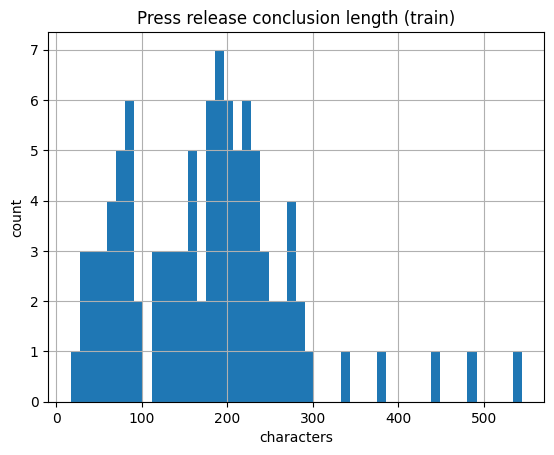

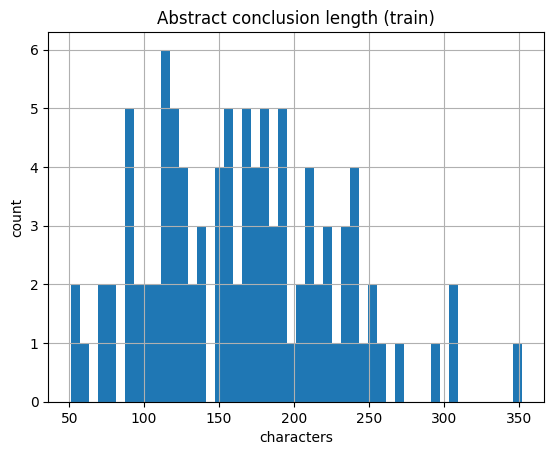

In [7]:
# lengths (characters)
df["pr_len"]  = df["press_release_conclusion"].astype(str).str.len()
df["abs_len"] = df["abstract_conclusion"].astype(str).str.len()

# press release conclusion length distribution
df["pr_len"].hist(bins=50)
plt.title("Press release conclusion length (train)")
plt.xlabel("characters")
plt.ylabel("count")
plt.show()

# abstract conclusion length distribution
df["abs_len"].hist(bins=50)
plt.title("Abstract conclusion length (train)")
plt.xlabel("characters")
plt.ylabel("count")
plt.show()


In [ ]:
#Looking for sequence lengths. This should give guidance for assigning MAX_SEQUENCE and truncation
#Roberta-base
roberta_tokenizer = AutoTokenizer.from_pretrained("roberta-base")

sample = df[["press_release_conclusion", "abstract_conclusion"]].dropna().head(5000)

def paired_sequence(pr, ab):
    enc = roberta_tokenizer(
        list(ab),                 # abstract sequence
        list(pr),                 # press release sequence
        add_special_tokens=True,
        truncation=False,
        padding=False,
        return_attention_mask=False
    )
    return np.array([len(x) for x in enc["input_ids"]])

sequence_lengths = paired_sequence(sample["press_release_conclusion"], sample["abstract_conclusion"])

dist_of_base_pair_inputs = np.quantile(sequence_lengths, [0.5, 0.9, 0.95, 0.99]), sequence_lengths.max()

dist_of_base_pair_inputs

(array([ 69.5,  95.2, 118.4, 131.1]), np.int64(141))